# NLP - Trabajo Práctico 1
Clasificador de Recomendaciones Recreativas utilizando Procesamiento de Lenguaje Natural (NLP)

Alumno: Pistelli, Pablo

2024

## Bases de datos

Para optimizar la ejecución del proyecto genero un notebook separado para el tratamiento de las bases de datos que se utilizarán en el sistema de recomendaciones.

Una vez finalizado el proceso se exportarán en nuevos CSV para utilizarlos en el modelo principal.

### Requerimientos

In [ ]:
# Reconocimiento de entidades nombradas en bases de datos
!pip install gliner

In [ ]:
# Bases de datos
import pandas as pd

# Scrapper
import requests
from bs4 import BeautifulSoup

# Búsqueda en bases de datos
from sentence_transformers import SentenceTransformer, util

# Manejo de embeddings
import numpy as np

# Reconocimiento de entidades nombradas en bases de datos
from gliner import GLiNER
from IPython.display import clear_output

### Generación de base de datos de libros

#### Lista de urls

La información de cada libro se encuentra en una página diferente.

Primero debemos obtener una lista de esas páginas para luego utilizar otro scrapper con cada una de ellas.

In [ ]:
url_top1000 = 'https://www.gutenberg.org/browse/scores/top1000.php#books-last30'

In [ ]:
headers = {"User-Agent": 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36'}
response = requests.get(url_top1000)
soup = BeautifulSoup(response.text, 'html.parser')
top1000 = soup.find_all('ol')

In [ ]:
len(top1000)

6

Cada sección *'ol'* corresponde a un Top 1000 diferente:
* [0] Top 1000 EBooks yesterday
* [1] Top 1000 Authors yesterday
* [2] Top 1000 EBooks last 7 days
* [3] Top 1000 Authors last 7 days
* [4] Top 1000 EBooks last 30 days
* [5] Top 1000 Authors last 30 days

Para nuestra base de datos elegiremos el **Top 1000 Eboks last 30 days**

In [ ]:
titulos_top1000 = top1000[4].find_all('li')

In [ ]:
titulos_top1000[0]

<li><a href="/ebooks/84">Frankenstein; Or, The Modern Prometheus by Mary Wollstonecraft Shelley (170672)</a></li>

In [ ]:
# Genero una lista para acceder a la url de cada libro
url_dominio = 'https://www.gutenberg.org'
urls_libros = []

for titulo in titulos_top1000:
  # En href se encuentra la subcarpeta y página con la información de cada título
  urls_libros.append(url_dominio + titulo.find('a').attrs['href'])

In [ ]:
urls_libros[0:20]

['https://www.gutenberg.org/ebooks/84',
 'https://www.gutenberg.org/ebooks/1342',
 'https://www.gutenberg.org/ebooks/1513',
 'https://www.gutenberg.org/ebooks/2701',
 'https://www.gutenberg.org/ebooks/25344',
 'https://www.gutenberg.org/ebooks/145',
 'https://www.gutenberg.org/ebooks/11',
 'https://www.gutenberg.org/ebooks/100',
 'https://www.gutenberg.org/ebooks/2641',
 'https://www.gutenberg.org/ebooks/37106',
 'https://www.gutenberg.org/ebooks/67979',
 'https://www.gutenberg.org/ebooks/16389',
 'https://www.gutenberg.org/ebooks/41',
 'https://www.gutenberg.org/ebooks/6761',
 'https://www.gutenberg.org/ebooks/394',
 'https://www.gutenberg.org/ebooks/2160',
 'https://www.gutenberg.org/ebooks/6593',
 'https://www.gutenberg.org/ebooks/4085',
 'https://www.gutenberg.org/ebooks/2542',
 'https://www.gutenberg.org/ebooks/5197']

In [ ]:
len(urls_libros)

1000

#### Extracción de información de títulos

Cada página de cada libro tiene una tabla con información, pero no todos los libros tienen la misma información disponible ni ordenada de la misma manera.

Para generar la base de datos extraigo:
* Title
* Author
* Summary
* Subjects
* URL

In [ ]:
# Generamos un DataFrame donde guardaremos la información extraída de cada url
df_libros = pd.DataFrame(columns=['Title', 'Author', 'Summary', 'Subjects', 'URL'])

In [ ]:
# Para cada url obtenida en el paso anterior extraemos la información de la tabla
for url_libro in urls_libros:
  response2 = requests.get(url_libro)
  response2.encoding = 'utf-8'
  soup2 = BeautifulSoup(response2.text, 'html.parser')
  tabla = soup2.find_all('table', {'class':'bibrec'} )

  # Obtenemos cada fila de la tabla
  tr=tabla[0].find_all('tr')

  # Generamos un diccionario en blanco para preparar los datos del libro actual
  nuevo_libro = {'Title':'', 'Author':'', 'Summary':'', 'Subjects':'', 'URL':url_libro}

  # Omitimos la última línea de la tabla porque no contiene datos sobre el libro
  tr.pop()

  # Un libro puede tener más de un tema. Generamos una lista de temas.
  temas = []

  # Extraemos los datos de interés
  for linea in tr:

    # Author
    if (linea.find('th').text == 'Author'):
      nuevo_libro['Author'] = linea.find_all('td')[0].text.replace('\n', '')

    # Title
    if (linea.find('th').text == 'Title'):
      nuevo_libro['Title'] = linea.find_all('td')[0].text.replace('\n', '')

    # Subjects
    if (linea.find('th').text == 'Subject'):
      temas.append(linea.find_all('td')[0].text.replace('\n', ''))

    # Summary
    if (linea.find('th').text == 'Summary'):
      nuevo_libro['Summary'] = linea.find_all('td')[0].text.replace('\n', '')

  nuevo_libro['Subjects'] = temas

  # Agregamos los datos del libro al DataFrame
  df_libros.loc[len(df_libros)] = nuevo_libro

#### Generación de CSV

In [ ]:
# Para preservar la base de datos generada y agilizar próximas ejecuciones, la guardo en formato .csv
df_libros.to_csv('Top1000_EBooks_ProjectGutemberg.csv', index=False, encoding='utf-8')

### Exploración de bases de datos

In [ ]:
# Bases de datos
juegos = pd.read_csv('/content/drive/MyDrive/TUIA/Procesamiento lenguaje Natural/TP1/Data/bgg_database.csv')
peliculas = pd.read_csv('/content/drive/MyDrive/TUIA/Procesamiento lenguaje Natural/TP1/Data/IMDB-Movie-Data.csv')
libros = pd.read_csv('/content/drive/MyDrive/TUIA/Procesamiento lenguaje Natural/TP1/Data/Top1000_EBooks_ProjectGutemberg.csv')

#### Juegos

In [ ]:
# Exploración de bases de datos provistas
juegos.head()

,rank,game_name,game_href,geek_rating,avg_rating,num_voters,description,yearpublished,minplayers,maxplayers,minplaytime,maxplaytime,minage,avgweight,best_num_players,designers,mechanics,categories
0,1,Brass: Birmingham,https://boardgamegeek.com/boardgame/224517/bra...,8.415,8.60,46836.0,Brass: Birmingham is an economic strategy game...,2018,2,4,60,120,14,3.8776,"[{'min': 3, 'max': 4}]","['Gavan Brown', 'Matt Tolman', 'Martin Wallace']","['Hand Management', 'Income', 'Loans', 'Market...","['Age of Reason', 'Economic', 'Industry / Manu..."
1,2,Pandemic Legacy: Season 1,https://boardgamegeek.com/boardgame/161936/pan...,8.377,8.53,53807.0,Pandemic Legacy is a co-operative campaign gam...,2015,2,4,60,60,13,2.8308,"[{'min': 4, 'max': 4}]","['Rob Daviau', 'Matt Leacock']","['Action Points', 'Cooperative Game', 'Hand Ma...","['Environmental', 'Medical']"
2,3,Gloomhaven,https://boardgamegeek.com/boardgame/174430/glo...,8.349,8.59,62592.0,Gloomhaven is a game of Euro-inspired tactica...,2017,1,4,60,120,14,3.9132,"[{'min': 3, 'max': 3}]",['Isaac Childres'],"['Action Queue', 'Action Retrieval', 'Campaign...","['Adventure', 'Exploration', 'Fantasy', 'Fight..."
3,4,Ark Nova,https://boardgamegeek.com/boardgame/342942/ark...,8.335,8.54,44728.0,"In Ark Nova, you will plan and design a modern...",2021,1,4,90,150,14,3.7653,"[{'min': 2, 'max': 2}]",['Mathias Wigge'],"['Action Queue', 'End Game Bonuses', 'Grid Cov...","['Animals', 'Economic', 'Environmental']"
4,5,Twilight Imperium: Fourth Edition,https://boardgamegeek.com/boardgame/233078/twi...,8.240,8.60,24148.0,Twilight Imperium (Fourth Edition) is a game o...,2017,3,6,240,480,14,4.3173,"[{'min': 6, 'max': 6}]","['Dane Beltrami', 'Corey Konieczka', 'Christia...","['Action Drafting', 'Area-Impulse', 'Dice Roll...","['Civilization', 'Economic', 'Exploration', 'N..."


#### Películas

In [ ]:
peliculas.head()

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40


#### Libros

In [ ]:
libros.head()

,Title,Author,Summary,Subjects,URL
0,"Frankenstein; Or, The Modern Prometheus","Shelley, Mary Wollstonecraft, 1797-1851","""Frankenstein; Or, The Modern Prometheus"" by M...","['Science fiction', 'Horror tales', 'Gothic fi...",https://www.gutenberg.org/ebooks/84
1,Romeo and Juliet,"Shakespeare, William, 1564-1616","""Romeo and Juliet"" by William Shakespeare is a...","['Vendetta -- Drama', 'Youth -- Drama', 'Veron...",https://www.gutenberg.org/ebooks/1513
2,Pride and Prejudice,"Austen, Jane, 1775-1817","""Pride and Prejudice"" by Jane Austen is a clas...","['England -- Fiction', 'Young women -- Fiction...",https://www.gutenberg.org/ebooks/1342
3,"Moby Dick; Or, The Whale","Melville, Herman, 1819-1891","""Moby Dick; Or, The Whale"" by Herman Melville ...","['Whaling -- Fiction', 'Sea stories', 'Psychol...",https://www.gutenberg.org/ebooks/2701
4,Middlemarch,"Eliot, George, 1819-1880","""Middlemarch"" by George Eliot is a novel writt...","['Didactic fiction', 'City and town life -- Fi...",https://www.gutenberg.org/ebooks/145


### Identificación de entidades nombradas

#### Modelo NER

Para enriquecer las bases de datos, se extraerán las entidades nombradas de las descripciones de cada una.

Todas las bases de datos están en inglés, por lo que es posible utilizar el modelo
**gliner-community/gliner_large-v2.5** que presenta una mejora en la performance frente al utilizado en el ejemplo de clase.

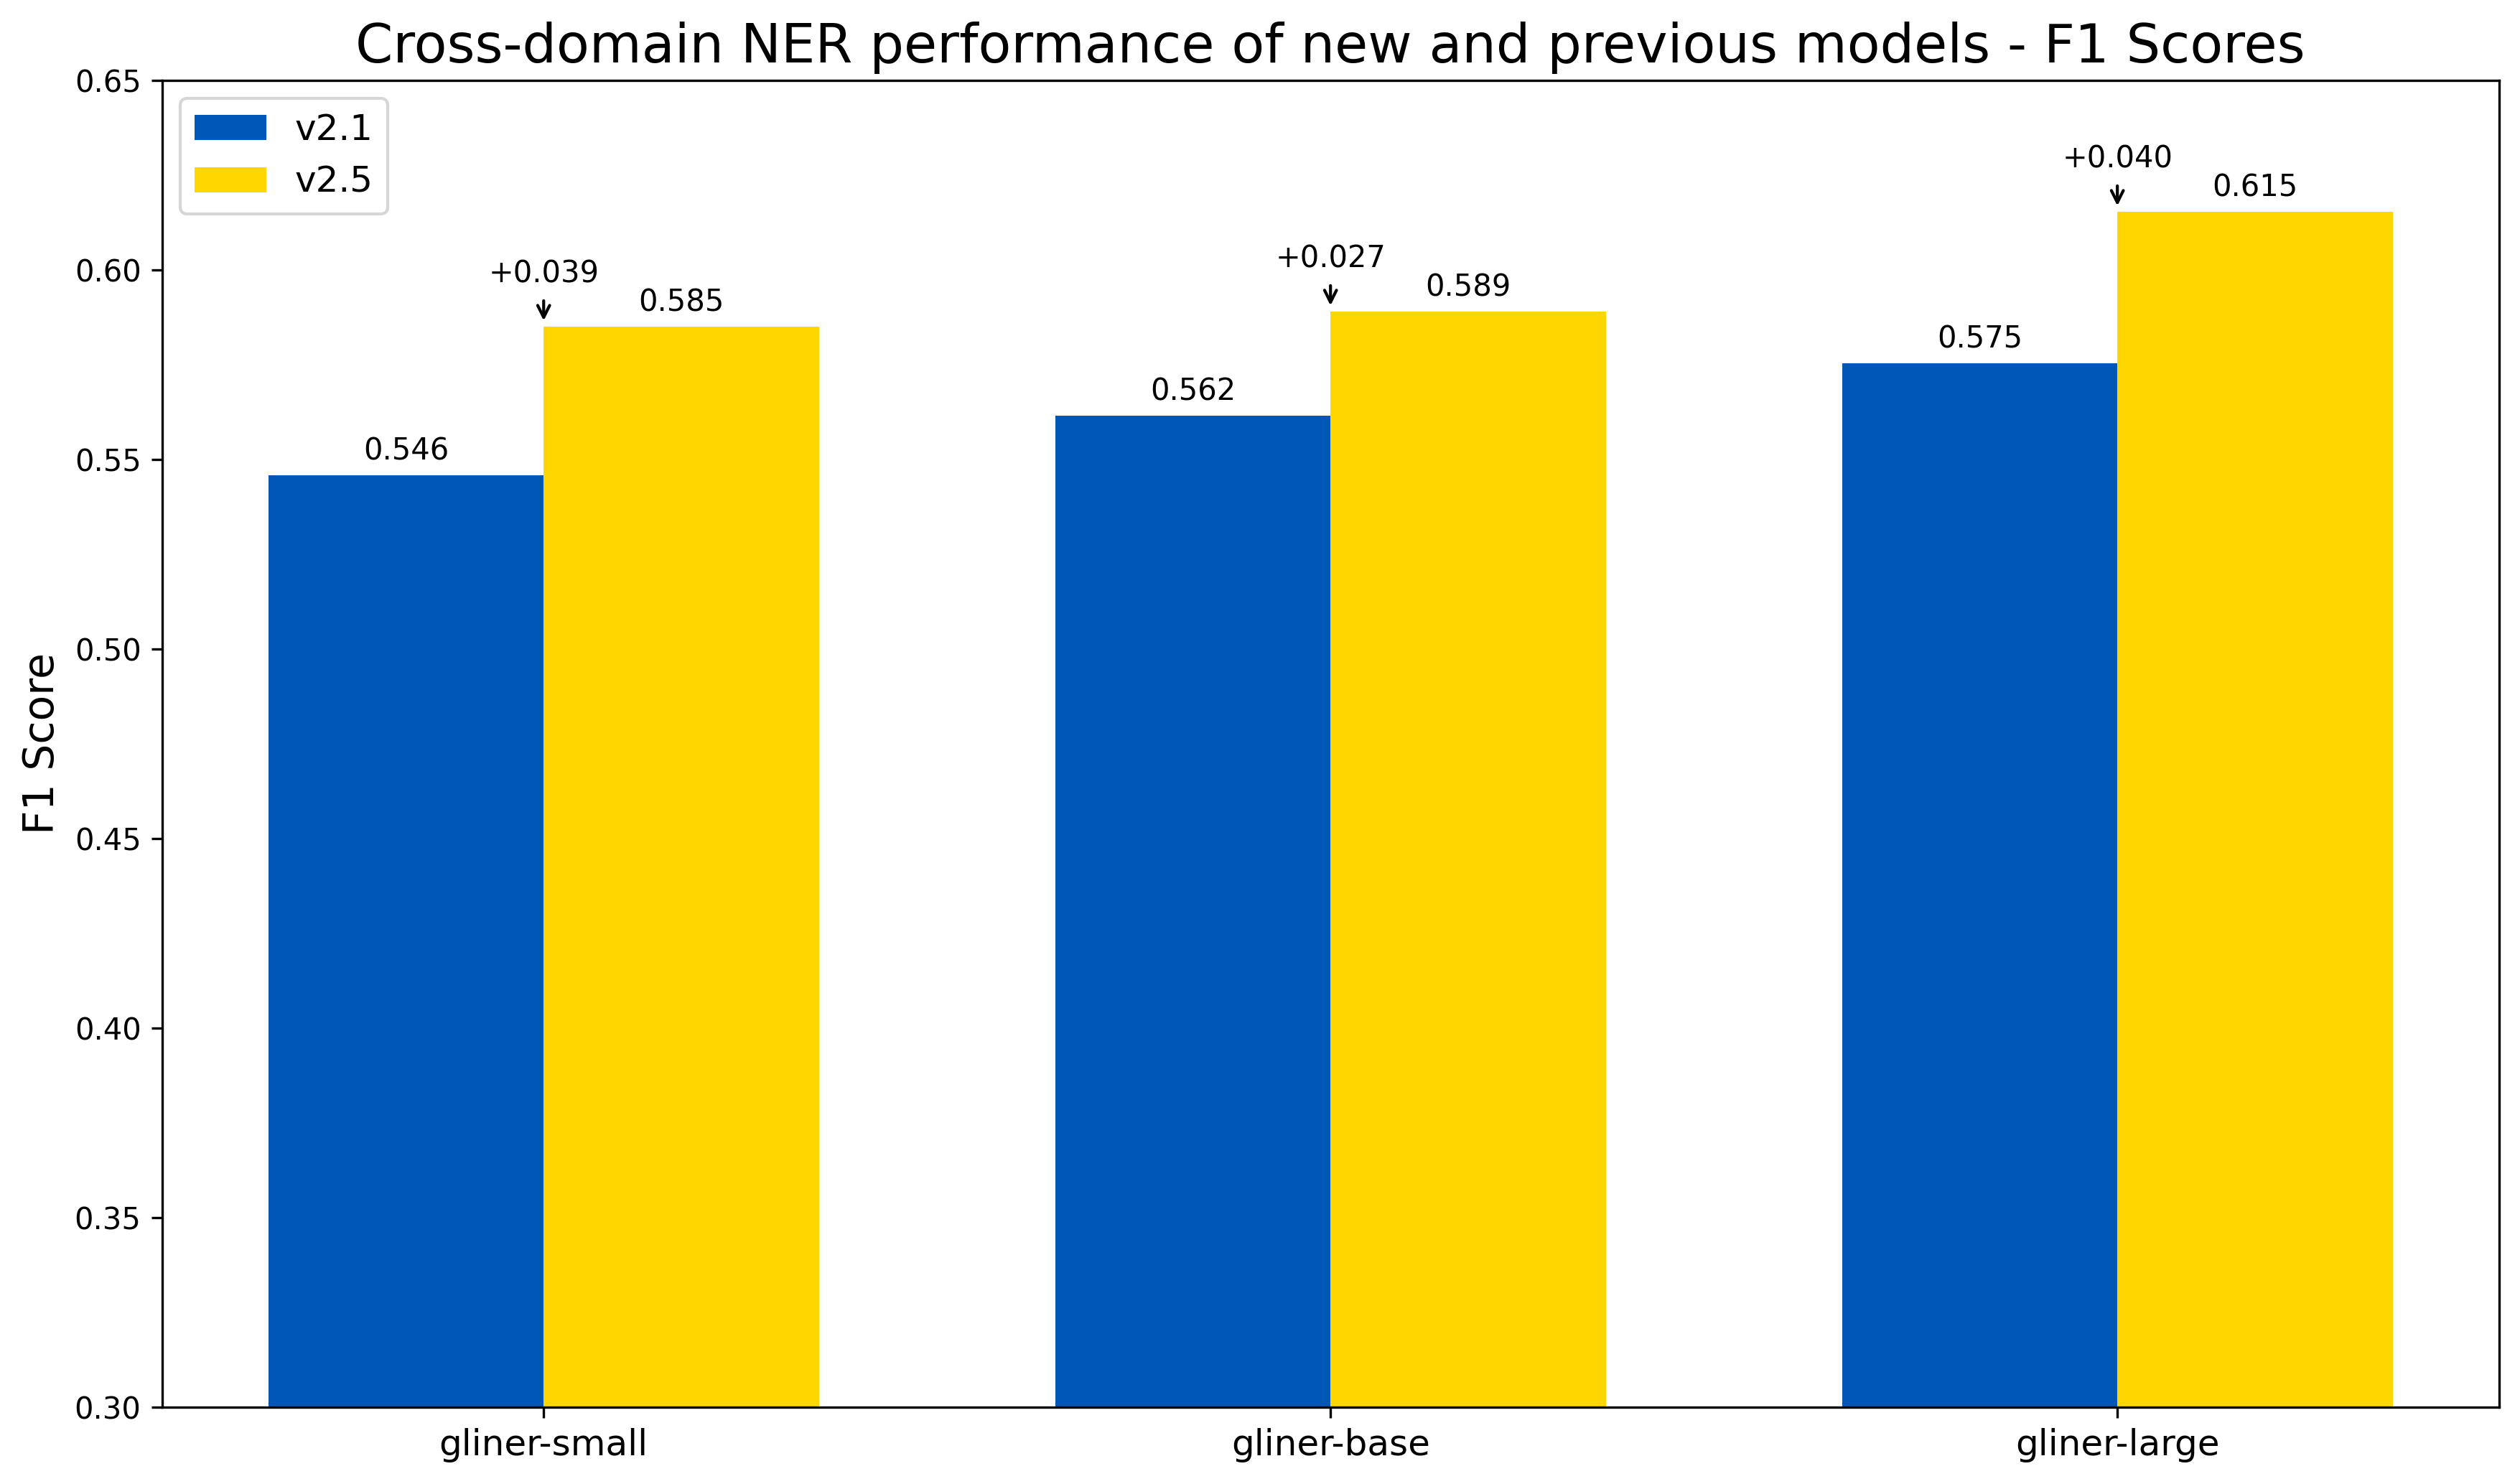

In [ ]:
# Carga de modelo preentrenado
# model = GLiNER.from_pretrained("urchade/gliner_multi-v2.1")
model = GLiNER.from_pretrained("gliner-community/gliner_large-v2.5")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.87k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.84G [00:00<?, ?B/s]

gliner_config.json:   0%|          | 0.00/676 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

models_comparison.png:   0%|          | 0.00/156k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/970 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.65M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

In [ ]:
# Cambia el modelo a modo de evaluación, esto es útil para desactivar características específicas como dropout durante la inferencia
model.eval()

# Tomo de ejemplo la descripción de un elemento de cada base de datos
text_pelicula = peliculas.loc[10, 'Description']
text_juego = juegos.loc[10, 'description']
text_libro = libros.loc[10, 'Summary']

# Lista de etiquetas que el modelo intentará encontrar en el texto
labels_pelicula = ["movie","person", "book", "location", "date", "actor", "character", ""]
labels_juego = ["game","mechanic", "character", "piece", "theme", "date", "author", "action", ""]
labels_libro = ["person", "book", "location", "date", "character", ""]

# Realiza la predicción de entidades en el texto dado, utilizando las etiquetas especificadas y un umbral de 0.4
entities_pelicula = model.predict_entities(text_pelicula, labels_pelicula, threshold=0.4)
entities_juego = model.predict_entities(text_juego, labels_juego, threshold=0.4)
entities_libro = model.predict_entities(text_libro, labels_libro, threshold=0.4)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
# Imprime cada entidad detectada junto con su etiqueta
print("Entidades en película:")
for entity in entities_pelicula:
    print(entity["text"], "=>", entity["label"])

# Imprime cada entidad detectada junto con su etiqueta
print("\nEntidades en juego:")
for entity in entities_juego:
    print(entity["text"], "=>", entity["label"])

# Imprime cada entidad detectada junto con su etiqueta
print("\nEntidades en libro:")
for entity in entities_libro:
    print(entity["text"], "=>", entity["label"])

Entidades en película:
Newt Scamander => character
New York => location
Harry Potter => character

Entidades en juego:
Spirit Island => game
energy => mechanic
ravage => action
ravage => action

Entidades en libro:
The Blue Castle => book
L. M. Montgomery => person
Valancy Stirling => character


#### Aplicación a las bases de datos

En cada dataframe se agrega una serie con las entidades nombradas extraídas de las descripciones/resúmenes.

In [ ]:
# Lista de etiquetas que el modelo intentará encontrar en el texto
labels_pelicula = ["movie","person", "book", "location", "date", "actor", "character", ""]
labels_juego = ["game","mechanic", "character", "piece", "theme", "date", "author", "action", ""]
labels_libro = ["person", "book", "location", "date", "character", ""]

##### NER Juegos

In [ ]:
# Genero una nueva serie dentro del dataframe que contenga las entidades identificadas
for i, description in enumerate(juegos['description']):
  clear_output(wait=True)
  print(f'Procesando juego: {i} / {juegos["description"].size}')
  juegos.loc[i,'entities'] = str(model.predict_entities(description, labels_juego, threshold=0.4))

Procesando juego: 999 / 1000


In [ ]:
juegos.head()

,rank,game_name,game_href,geek_rating,avg_rating,num_voters,description,yearpublished,minplayers,maxplayers,minplaytime,maxplaytime,minage,avgweight,best_num_players,designers,mechanics,categories,entities
0,1,Brass: Birmingham,https://boardgamegeek.com/boardgame/224517/bra...,8.415,8.60,46836.0,Brass: Birmingham is an economic strategy game...,2018,2,4,60,120,14,3.8776,"[{'min': 3, 'max': 4}]","['Gavan Brown', 'Matt Tolman', 'Martin Wallace']","['Hand Management', 'Income', 'Loans', 'Market...","['Age of Reason', 'Economic', 'Industry / Manu...","[{'start': 57, 'end': 71, 'text': 'Martin Wall..."
1,2,Pandemic Legacy: Season 1,https://boardgamegeek.com/boardgame/161936/pan...,8.377,8.53,53807.0,Pandemic Legacy is a co-operative campaign gam...,2015,2,4,60,60,13,2.8308,"[{'min': 4, 'max': 4}]","['Rob Daviau', 'Matt Leacock']","['Action Points', 'Cooperative Game', 'Hand Ma...","['Environmental', 'Medical']","[{'start': 0, 'end': 15, 'text': 'Pandemic Leg..."
2,3,Gloomhaven,https://boardgamegeek.com/boardgame/174430/glo...,8.349,8.59,62592.0,Gloomhaven is a game of Euro-inspired tactica...,2017,1,4,60,120,14,3.9132,"[{'min': 3, 'max': 3}]",['Isaac Childres'],"['Action Queue', 'Action Retrieval', 'Campaign...","['Adventure', 'Exploration', 'Fantasy', 'Fight...","[{'start': 25, 'end': 54, 'text': 'Euro-inspir..."
3,4,Ark Nova,https://boardgamegeek.com/boardgame/342942/ark...,8.335,8.54,44728.0,"In Ark Nova, you will plan and design a modern...",2021,1,4,90,150,14,3.7653,"[{'min': 2, 'max': 2}]",['Mathias Wigge'],"['Action Queue', 'End Game Bonuses', 'Grid Cov...","['Animals', 'Economic', 'Environmental']","[{'start': 3, 'end': 11, 'text': 'Ark Nova', '..."
4,5,Twilight Imperium: Fourth Edition,https://boardgamegeek.com/boardgame/233078/twi...,8.240,8.60,24148.0,Twilight Imperium (Fourth Edition) is a game o...,2017,3,6,240,480,14,4.3173,"[{'min': 6, 'max': 6}]","['Dane Beltrami', 'Corey Konieczka', 'Christia...","['Action Drafting', 'Area-Impulse', 'Dice Roll...","['Civilization', 'Economic', 'Exploration', 'N...","[{'start': 331, 'end': 347, 'text': 'Ghosts of..."


In [ ]:
# Para preservar la base de datos generada y agilizar próximas ejecuciones, la guardo en formato .csv
juegos.to_csv('bgg_database_NER.csv', index=False, encoding='utf-8')

##### NER Películas

In [ ]:
# Genero una nueva serie dentro del dataframe que contenga las entidades identificadas
for i, description in enumerate(peliculas['Description']):
  clear_output(wait=True)
  print(f'Procesando película: {i} / {peliculas["Description"].size}')
  peliculas.loc[i,'entities'] = str(model.predict_entities(description, labels_pelicula, threshold=0.4))

Procesando película: 999 / 1000


In [ ]:
peliculas.head()

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore,entities
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76,"[{'start': 11, 'end': 34, 'text': 'intergalact..."
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65,"[{'start': 80, 'end': 84, 'text': 'moon', 'lab..."
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62,"[{'start': 0, 'end': 11, 'text': 'Three girls'..."
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59,"[{'start': 5, 'end': 29, 'text': 'city of huma..."
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40,"[{'start': 0, 'end': 26, 'text': 'A secret gov..."


In [ ]:
# Para preservar la base de datos generada y agilizar próximas ejecuciones, la guardo en formato .csv
peliculas.to_csv('IMDB-Movie-Data_NER.csv', index=False, encoding='utf-8')

##### NER Libros

In [ ]:
# Genero una nueva serie dentro del dataframe que contenga las entidades identificadas
# Algunos libros no tenían resumen, para esos casos omito la identificación de entidades
for i, summary in enumerate(libros['Summary'].dropna()):
  clear_output(wait=True)
  print(f'Procesando libro: {i} / {libros["Summary"].size}')
  if pd.notna(summary):
    libros.loc[i,'entities'] = str(model.predict_entities(summary, labels_libro, threshold=0.4))

Procesando libro: 927 / 1000


In [ ]:
libros.head()

,Title,Author,Summary,Subjects,URL,entities
0,"Frankenstein; Or, The Modern Prometheus","Shelley, Mary Wollstonecraft, 1797-1851","""Frankenstein; Or, The Modern Prometheus"" by M...","['Science fiction', 'Horror tales', 'Gothic fi...",https://www.gutenberg.org/ebooks/84,"[{'start': 1, 'end': 40, 'text': 'Frankenstein..."
1,Romeo and Juliet,"Shakespeare, William, 1564-1616","""Romeo and Juliet"" by William Shakespeare is a...","['Vendetta -- Drama', 'Youth -- Drama', 'Veron...",https://www.gutenberg.org/ebooks/1513,"[{'start': 1, 'end': 17, 'text': 'Romeo and Ju..."
2,Pride and Prejudice,"Austen, Jane, 1775-1817","""Pride and Prejudice"" by Jane Austen is a clas...","['England -- Fiction', 'Young women -- Fiction...",https://www.gutenberg.org/ebooks/1342,"[{'start': 1, 'end': 20, 'text': 'Pride and Pr..."
3,"Moby Dick; Or, The Whale","Melville, Herman, 1819-1891","""Moby Dick; Or, The Whale"" by Herman Melville ...","['Whaling -- Fiction', 'Sea stories', 'Psychol...",https://www.gutenberg.org/ebooks/2701,"[{'start': 1, 'end': 25, 'text': 'Moby Dick; O..."
4,Middlemarch,"Eliot, George, 1819-1880","""Middlemarch"" by George Eliot is a novel writt...","['Didactic fiction', 'City and town life -- Fi...",https://www.gutenberg.org/ebooks/145,"[{'start': 1, 'end': 12, 'text': 'Middlemarch'..."


In [ ]:
# Para preservar la base de datos generada y agilizar próximas ejecuciones, la guardo en formato .csv
libros.to_csv('Top1000_EBooks_ProjectGutemberg_NER.csv', index=False, encoding='utf-8')

### Embeddings de bases de datos

Genero los embeddings de las bases de datos y los exporto para utilizarlos en el sistema de recomendaciones.


In [ ]:
modelo = SentenceTransformer('msmarco-MiniLM-L-6-v3')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.72k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Genero las incrustaciones para todas las bases de datos para luego realizar las consultas
incrustaciones_juegos = modelo.encode(juegos['description'].astype(str).tolist())
incrustaciones_peliculas = modelo.encode(peliculas['Description'].astype(str).tolist())
incrustaciones_libros = modelo.encode(libros['Summary'].astype(str).tolist())

In [ ]:
# Para agilizar las ejecuciones siguientes, guardo las incrustaciones
# en archivos .npy para no tener que generarlos cada vez
np.save('incrustaciones_juegos.npy', incrustaciones_juegos)
np.save('incrustaciones_peliculas.npy', incrustaciones_peliculas)
np.save('incrustaciones_libros.npy', incrustaciones_libros)

In [ ]:
# Cargar incrustaciones guardadas
incrustaciones_juegos = np.load('incrustaciones_juegos.npy')
incrustaciones_peliculas = np.load('incrustaciones_peliculas.npy')
incrustaciones_libros = np.load('incrustaciones_libros.npy')